In [23]:
import sys
sys.path.insert(0, '/home/ektov-av/python35-libs/lib/python3.5/site-packages/') 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
import os
import joblib

from collections import defaultdict

from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, \
                            classification_report, precision_score, \
                            recall_score, roc_curve, precision_recall_curve, \
                            average_precision_score, recall_score, make_scorer, \
                            classification_report, average_precision_score, confusion_matrix
                
from sklearn.preprocessing import LabelEncoder, binarize
                
from sklearn.cross_validation import train_test_split, cross_val_predict

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedShuffleSplit, GridSearchCV, \
                                    cross_validate

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier

from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from hyperopt.pyll import scope

pd.set_option('display.max_columns', None)

%matplotlib inline
pd.options.display.max_columns = 1000

In [24]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', UserWarning)

In [25]:
def get_path(folder, file):
    return os.path.join(folder, file)

In [26]:
def top_feature_save(model, X_train, file_name, count_top_features = 20):
    imp=model.feature_importances_
    names=X_train.columns
    imp, names=map(list, zip(*sorted(zip(imp, names))[::-1][:count_top_features]))
    dict_imp=dict(zip(names,imp))
    joblib.dump(dict_imp, 'pkl_store/'+file_name+'.pkl')

In [27]:
def feature_impotance(model, X_train, count_top_features = 20):
    imp=model.feature_importances_
    names=X_train.columns
    imp, names=map(list, zip(*sorted(zip(imp, names))[::-1][:count_top_features]))
    
    fig, ax = plt.subplots(figsize=(7,9))
    #ax = plt.axes()
    sns.barplot(x=imp, y=names, palette=sns.color_palette('YlGn', 2), ax=ax)
    ax.set_title('Top ' + str(count_top_features) + ' important features')
    plt.show()

def predict(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    print('AUC: %.5f, Precision: %.5f, Recall: %.5f, F1: %.5f \n' % (roc_auc_score(y_test, y_pred_proba), \
                                    precision_score(y_test, y_pred), recall_score(y_test, y_pred), 
                                                                     f1_score(y_test, y_pred)))
    print('Average precision: %.5f \n' % average_precision_score(y_test, y_pred_proba))
    print(classification_report(y_test, y_pred, digits=5))
    confusion_matrix_heatmap(y_test, y_pred)
    
def confusion_matrix_heatmap(y_test, y_pred):
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Fetching data

In [28]:
df = pd.read_pickle('pkl_store/total_dataset_unencoded.pkl')

In [29]:
df.head()

is_sold                           tb                     gosb  \
0        0       Западно-Сибирский банк     Тюменское ГОСБ №0029   
1        0               Сибирский банк       Томское ГОСБ №8616   
2        1  Центрально-Черноземный банк      Липецкое ГОСБ №8593   
3        1              Поволжский банк  Оренбургское ГОСБ №8623   
4        1               Уральский банк    Курганское ГОСБ №8599   

                                             product  \
0                                       1948/Доверие   
1                                 Депозиты (срочные)   
2                          Пакет услуг Удачный сезон   
3                                    ПУ Легкий старт   
4  Открытие банковского счета с договором-констру...   

                  product_group  days_cr_q_end segment_client priority_client  \
0                  КРЕДИТОВАНИЕ             52          Микро        Ключевой   
1  ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ             25          Микро        Ключевой   
2                  ПАКЕТЫ УСЛУГ             23          Микро        Ключевой   
3                  ПАКЕТЫ УСЛУГ             19          Микро             Нет   
4                           РКО             75          Микро             Нет   

   sum_sold  sum_sold_cumulate  sum_refused  sum_refused_cumulate  \
0       0.0                1.0          0.0                   0.0   
1       4.0               22.0          1.0                   1.0   
2       0.0                0.0          0.0                   0.0   
3       0.0                2.0          0.0                   0.0   
4       1.0               17.0          0.0                   0.0   

   sum_sold_total  sum_sold_total_cumulate  sum_refused_total  \
0             2.0                      4.0                0.0   
1             6.0                     24.0               18.0   
2             1.0                     33.0                3.0   
3             1.0                     20.0                0.0   
4             6.0                     95.0                5.0   

   sum_refused_tota_cumulate  sum_sold_company_shift_1  \
0                        2.0                       0.0   
1                        3.0                       1.0   
2                       26.0                       0.0   
3                       13.0                       0.0   
4                       25.0                       0.0   

   sum_sold_cumulate_company_shift_1  sum_refused_company_shift_1  \
0                                0.0                          0.0   
1                                0.0                          0.0   
2                                0.0                          0.0   
3                                0.0                          0.0   
4                                0.0                          0.0   

   sum_refused_cumulate_company_shift_1  sum_sold_total_company_shift_1  \
0                                   0.0                             0.0   
1                                   0.0                             1.0   
2                                   0.0                             0.0   
3                                   0.0                             0.0   
4                                   0.0                             0.0   

   sum_sold_total_cumulate_company_shift_1  sum_refused_total_company_shift_1  \
0                                      0.0                                0.0   
1                                      1.0                                0.0   
2                                      0.0                                0.0   
3                                      0.0                                0.0   
4                                      0.0                                0.0   

   sum_refused_total_cumulate  sum_sold_km_shift_2  \
0                         0.0                  0.0   
1                         0.0                  3.0   
2                         0.0                  0.0   
3                         0.0                 

In [30]:
df.shape

(415886, 267)

In [31]:
balance = pd.concat([df.groupby('product_group')['is_sold'].sum(), 
                     df.groupby('product_group')['is_sold'].count()], axis=1)
balance.columns = ['Sum of sold', 'Count']
balance['balance'] = balance['Sum of sold'] / balance['Count']
balance = balance.sort_values('balance', ascending=False)
balance

Sum of sold  Count   balance
product_group                                                         
РОЗНИЧНЫЕ ПРОДУКТЫ                                  2      2  1.000000
ВЕКСЕЛЯ                                            98     98  1.000000
АРЕНДА СЕЙФОВ                                       1      1  1.000000
ИНФОРМАЦИОННЫЕ УСЛУГИ                           17565  18384  0.955450
РКО                                             66961  70256  0.953100
ИНКАССАЦИЯ                                      26211  27795  0.943011
ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ                    43786  47067  0.930291
ПАКЕТЫ УСЛУГ                                    34425  37732  0.912356
КОНВЕРСИОННЫЕ ОПЕРАЦИИ                            233    256  0.910156
ДЕПОЗИТНЫЕ СЕРТИФИКАТЫ                             59     67  0.880597
ДЕЛОВАЯ СРЕДА                                     286    336  0.851190
ВАЛЮТНЫЙ КОНТРОЛЬ                                 243    296  0.820946
ДОСТАВКА ДЕНЕЖНОЙ НАЛИЧНОСТИ И ЦЕННОСТЕЙ            3      4  0.750000
СТРАХОВАНИЕ                                      5838   8206  0.711431
ПРИЕМ ПЛАТЕЖЕЙ ФИЗ. ЛИЦ                             7     10  0.700000
ЭКВАЙРИНГ                                       12439  18068  0.688455
БИЗНЕС-КАРТА                                    36442  53576  0.680193
БАНКОВСКАЯ ГАРАНТИЯ                              2851   4466  0.638379
ЗАРПЛАТНЫЕ ПРОЕКТЫ                              31485  51330  0.613384
ЭВОТОР                                           3301   5398  0.611523
КРЕДИТНАЯ БИЗНЕС-КАРТА                           3648   6467  0.564095
ВНЕШНИЙ МИКРО СМАРТ                                41     73  0.561644
ИНВЕСТИЦИОННЫЕ ПРОДУКТЫ                             5      9  0.555556
ВНЕШНИЙ МАЛЫЙ СМАРТ                                 8     17  0.470588
КРЕДИТОВАНИЕ                                    19180  57437  0.333931
ДОКУМЕНТАРНЫЕ ОПЕРАЦИИ                              9     27  0.333333
ДИСТАНЦИОННОЕ ОБСЛУЖИВАНИЕ                       2636   8292  0.317897
ПРЕМИАЛЬНАЯ БИЗНЕС-КАРТА                           31    131  0.236641
CASH MANAGEMENT                                     6     39  0.153846
ТЕХНИЧЕСКИЕ ПРОДУКТЫ                                3     32  0.093750
ФАКТОРИНГ                                           1     13  0.076923
КАРТА ДАЛЬНОБОЙЩИКА                                 0      1  0.000000

In [32]:
balance['balance'].index

Index(['РОЗНИЧНЫЕ ПРОДУКТЫ', 'ВЕКСЕЛЯ', 'АРЕНДА СЕЙФОВ',
       'ИНФОРМАЦИОННЫЕ УСЛУГИ', 'РКО', 'ИНКАССАЦИЯ',
       'ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ', 'ПАКЕТЫ УСЛУГ',
       'КОНВЕРСИОННЫЕ ОПЕРАЦИИ', 'ДЕПОЗИТНЫЕ СЕРТИФИКАТЫ', 'ДЕЛОВАЯ СРЕДА',
       'ВАЛЮТНЫЙ КОНТРОЛЬ', 'ДОСТАВКА ДЕНЕЖНОЙ НАЛИЧНОСТИ И ЦЕННОСТЕЙ',
       'СТРАХОВАНИЕ', 'ПРИЕМ ПЛАТЕЖЕЙ ФИЗ. ЛИЦ', 'ЭКВАЙРИНГ', 'БИЗНЕС-КАРТА',
       'БАНКОВСКАЯ ГАРАНТИЯ', 'ЗАРПЛАТНЫЕ ПРОЕКТЫ', 'ЭВОТОР',
       'КРЕДИТНАЯ БИЗНЕС-КАРТА', 'ВНЕШНИЙ МИКРО СМАРТ',
       'ИНВЕСТИЦИОННЫЕ ПРОДУКТЫ', 'ВНЕШНИЙ МАЛЫЙ СМАРТ', 'КРЕДИТОВАНИЕ',
       'ДОКУМЕНТАРНЫЕ ОПЕРАЦИИ', 'ДИСТАНЦИОННОЕ ОБСЛУЖИВАНИЕ',
       'ПРЕМИАЛЬНАЯ БИЗНЕС-КАРТА', 'CASH MANAGEMENT', 'ТЕХНИЧЕСКИЕ ПРОДУКТЫ',
       'ФАКТОРИНГ', 'КАРТА ДАЛЬНОБОЙЩИКА'],
      dtype='object', name='product_group')

In [33]:
product_groups_without_balance = list(balance[(balance['balance'] == 1) | (balance['balance'] == 0)].index)

In [34]:
product_groups_without_balance_dict = balance[(balance['balance'] == 1) | 
                                              (balance['balance'] == 0)]['balance'].to_dict()
product_groups_without_balance_dict

{'АРЕНДА СЕЙФОВ': 1.0,
 'ВЕКСЕЛЯ': 1.0,
 'КАРТА ДАЛЬНОБОЙЩИКА': 0.0,
 'РОЗНИЧНЫЕ ПРОДУКТЫ': 1.0}

In [35]:
df = df[~df['product_group'].isin(product_groups_without_balance)]

In [36]:
list(df.columns)

['is_sold',
 'tb',
 'gosb',
 'product',
 'product_group',
 'days_cr_q_end',
 'segment_client',
 'priority_client',
 'sum_sold',
 'sum_sold_cumulate',
 'sum_refused',
 'sum_refused_cumulate',
 'sum_sold_total',
 'sum_sold_total_cumulate',
 'sum_refused_total',
 'sum_refused_tota_cumulate',
 'sum_sold_company_shift_1',
 'sum_sold_cumulate_company_shift_1',
 'sum_refused_company_shift_1',
 'sum_refused_cumulate_company_shift_1',
 'sum_sold_total_company_shift_1',
 'sum_sold_total_cumulate_company_shift_1',
 'sum_refused_total_company_shift_1',
 'sum_refused_total_cumulate',
 'sum_sold_km_shift_2',
 'sum_sold_cumulate_km_shift_2',
 'sum_refused_km_shift_2',
 'sum_refused_cumulate_km_shift_2',
 'sum_sold_total_km_shift_2',
 'sum_sold_total_cumulate_km_shift_2',
 'sum_refused_total_km_shift_2',
 'sum_refused_tota_cumulate_km_shift_2',
 'sum_sold_company_shift_2',
 'sum_sold_cumulate_company_shift_2',
 'sum_refused_company_shift_2',
 'sum_refused_cumulate_company_shift_2',
 'sum_sold_total_co

In [37]:
df.head()

is_sold                           tb                     gosb  \
0        0       Западно-Сибирский банк     Тюменское ГОСБ №0029   
1        0               Сибирский банк       Томское ГОСБ №8616   
2        1  Центрально-Черноземный банк      Липецкое ГОСБ №8593   
3        1              Поволжский банк  Оренбургское ГОСБ №8623   
4        1               Уральский банк    Курганское ГОСБ №8599   

                                             product  \
0                                       1948/Доверие   
1                                 Депозиты (срочные)   
2                          Пакет услуг Удачный сезон   
3                                    ПУ Легкий старт   
4  Открытие банковского счета с договором-констру...   

                  product_group  days_cr_q_end segment_client priority_client  \
0                  КРЕДИТОВАНИЕ             52          Микро        Ключевой   
1  ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ             25          Микро        Ключевой   
2                  ПАКЕТЫ УСЛУГ             23          Микро        Ключевой   
3                  ПАКЕТЫ УСЛУГ             19          Микро             Нет   
4                           РКО             75          Микро             Нет   

   sum_sold  sum_sold_cumulate  sum_refused  sum_refused_cumulate  \
0       0.0                1.0          0.0                   0.0   
1       4.0               22.0          1.0                   1.0   
2       0.0                0.0          0.0                   0.0   
3       0.0                2.0          0.0                   0.0   
4       1.0               17.0          0.0                   0.0   

   sum_sold_total  sum_sold_total_cumulate  sum_refused_total  \
0             2.0                      4.0                0.0   
1             6.0                     24.0               18.0   
2             1.0                     33.0                3.0   
3             1.0                     20.0                0.0   
4             6.0                     95.0                5.0   

   sum_refused_tota_cumulate  sum_sold_company_shift_1  \
0                        2.0                       0.0   
1                        3.0                       1.0   
2                       26.0                       0.0   
3                       13.0                       0.0   
4                       25.0                       0.0   

   sum_sold_cumulate_company_shift_1  sum_refused_company_shift_1  \
0                                0.0                          0.0   
1                                0.0                          0.0   
2                                0.0                          0.0   
3                                0.0                          0.0   
4                                0.0                          0.0   

   sum_refused_cumulate_company_shift_1  sum_sold_total_company_shift_1  \
0                                   0.0                             0.0   
1                                   0.0                             1.0   
2                                   0.0                             0.0   
3                                   0.0                             0.0   
4                                   0.0                             0.0   

   sum_sold_total_cumulate_company_shift_1  sum_refused_total_company_shift_1  \
0                                      0.0                                0.0   
1                                      1.0                                0.0   
2                                      0.0                                0.0   
3                                      0.0                                0.0   
4                                      0.0                                0.0   

   sum_refused_total_cumulate  sum_sold_km_shift_2  \
0                         0.0                  0.0   
1                         0.0                  3.0   
2                         0.0                  0.0   
3                         0.0                 

In [38]:
unique_counts = pd.DataFrame()
for col in df.columns:
    unique_counts = unique_counts.append([[col, len(df[col].unique())]])
unique_counts.columns = ['colname', 'unique_counts']
unique_counts.head()

colname  unique_counts
0        is_sold              2
0             tb             14
0           gosb             90
0        product            132
0  product_group             28

In [39]:
non_unique_columns = unique_counts[unique_counts['unique_counts'] == 1]['colname'].values
non_unique_columns

array([], dtype=object)

In [40]:
target_column = 'is_sold'
#drop_columns = ['ckp']
#X, y = df.drop(target_column, axis = 1).drop(drop_columns, 1), df[target_column]
X, y = df.drop(non_unique_columns, axis = 1).drop(target_column, axis = 1), df[target_column]

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.35, random_state=42)

## Label Encoding

In [42]:
from label_encoder import SoftLabelEncoder

In [46]:
label_encoders = {}
for col in X_train.dtypes[X_train.dtypes == 'O'].index:
    le = SoftLabelEncoder()
    X_train[col] = le.fit_transform(X_train.loc[:,col].fillna('NaN'))
    label_encoders[col] = le

In [47]:
joblib.dump(label_encoders, get_path('pkl_store', 'label_encoders_all.pkl'))

['pkl_store/label_encoders_all.pkl']

In [48]:
for col in X_test.dtypes[X_test.dtypes == 'O'].index:
    X_test[col] = label_encoders[col].transform(X_test.loc[:,col].fillna('NaN'))

In [224]:
le=joblib.load(get_path('pkl_store', 'label_encoders_trn.pkl'))
cat_features=list(set(le.keys()))
cat_features

['tb', 'product_group', 'gosb', 'product', 'priority_client', 'segment_client']

In [175]:
#cat_features = [col for col in cat_features if col in X_train.columns]

## Fit model

In [176]:
from lightgbm import LGBMClassifier, plot_metric, plot_importance

In [177]:
gbm = LGBMClassifier(n_estimators=15000, num_leaves=150, max_bin=100, bagging_fraction=0.8, bagging_freq=10, n_jobs=60, 
                     feature_fraction=0.5, lambda_l1=0, lambda_l2=1, min_child_weight=1e-05,
                     min_data_in_leaf=100, random_state=42)

In [178]:
%%time
gbm.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=15,
        eval_metric=['auc', 'logloss'], categorical_feature=cat_features, verbose=True)

[1]	training's auc: 0.853211	valid_1's auc: 0.52257
Training until validation scores don't improve for 15 rounds.
[2]	training's auc: 0.856195	valid_1's auc: 0.582947
[3]	training's auc: 0.857545	valid_1's auc: 0.575995
[4]	training's auc: 0.859988	valid_1's auc: 0.678834
[5]	training's auc: 0.85934	valid_1's auc: 0.725091
[6]	training's auc: 0.860255	valid_1's auc: 0.723644
[7]	training's auc: 0.861626	valid_1's auc: 0.730305
[8]	training's auc: 0.86428	valid_1's auc: 0.735247
[9]	training's auc: 0.865764	valid_1's auc: 0.736198
[10]	training's auc: 0.86667	valid_1's auc: 0.739082
[11]	training's auc: 0.867089	valid_1's auc: 0.750905
[12]	training's auc: 0.867903	valid_1's auc: 0.751397
[13]	training's auc: 0.870984	valid_1's auc: 0.747627
[14]	training's auc: 0.870981	valid_1's auc: 0.758466
[15]	training's auc: 0.871796	valid_1's auc: 0.755415
[16]	training's auc: 0.872099	valid_1's auc: 0.753637
[17]	training's auc: 0.873154	valid_1's auc: 0.750954
[18]	training's auc: 0.874023	val

LGBMClassifier(bagging_fraction=0.8, bagging_freq=10, boosting_type='gbdt',
        colsample_bytree=1.0, feature_fraction=0.5, lambda_l1=0,
        lambda_l2=1, learning_rate=0.1, max_bin=100, max_depth=-1,
        min_child_samples=10, min_child_weight=1e-05, min_data_in_leaf=100,
        min_split_gain=0.0, n_estimators=15000, n_jobs=60, num_leaves=150,
        objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=50000,
        subsample_freq=1)

AUC: 0.76737, Precision: 0.80044, Recall: 0.89500, F1: 0.84508 

Average precision: 0.90235 

             precision    recall  f1-score   support

          0    0.54662   0.36198   0.43553     37707
          1    0.80044   0.89500   0.84508    107818

avg / total    0.73467   0.75689   0.73896    145525



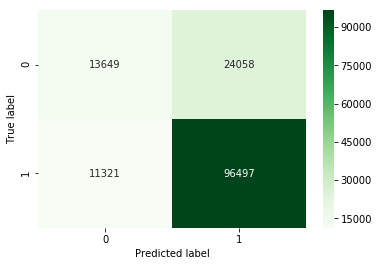

In [179]:
predict(gbm, X_test, y_test)

## RFE

In [180]:
from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedShuffleSplit, GroupShuffleSplit
from sklearn.metrics import make_scorer
from lightgbm import LGBMClassifier, plot_metric, plot_importance

import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode()

In [181]:
gbm = LGBMClassifier(n_estimators=1000, num_leaves=10, max_bin=100, bagging_freq=20, n_jobs=100, feature_fraction=0.5,\
                     min_data_in_leaf=100,  silent=False, random_state=42)

In [182]:
n_splits=4
#cvs=[StratifiedKFold(n_splits), StratifiedShuffleSplit(n_splits)]
cvs=[StratifiedShuffleSplit(n_splits)]
scores=[]
split_names=[]

In [183]:
for cv in cvs:
    rfe = RFECV(gbm, cv=cv, step=1, scoring='average_precision', verbose=2)
    print('Running CV with ' + type(rfe.cv).__name__ + '\n')
    rfe.fit(X_test, y_test)
    scores.append(rfe.grid_scores_)
    split_names.append(type(rfe.cv).__name__)

Running CV with StratifiedShuffleSplit

Fitting estimator with 266 features.
Fitting estimator with 265 features.
Fitting estimator with 264 features.
Fitting estimator with 263 features.
Fitting estimator with 262 features.
Fitting estimator with 261 features.
Fitting estimator with 260 features.
Fitting estimator with 259 features.
Fitting estimator with 258 features.
Fitting estimator with 257 features.
Fitting estimator with 256 features.
Fitting estimator with 255 features.
Fitting estimator with 254 features.
Fitting estimator with 253 features.
Fitting estimator with 252 features.
Fitting estimator with 251 features.
Fitting estimator with 250 features.
Fitting estimator with 249 features.
Fitting estimator with 248 features.
Fitting estimator with 247 features.
Fitting estimator with 246 features.
Fitting estimator with 245 features.
Fitting estimator with 244 features.
Fitting estimator with 243 features.
Fitting estimator with 242 features.
Fitting estimator with 241 features

Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 fe

Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 fe

Fitting estimator with 126 features.
Fitting estimator with 125 features.
Fitting estimator with 124 features.
Fitting estimator with 123 features.
Fitting estimator with 122 features.
Fitting estimator with 121 features.
Fitting estimator with 120 features.
Fitting estimator with 119 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
F

Fitting estimator with 166 features.
Fitting estimator with 165 features.
Fitting estimator with 164 features.
Fitting estimator with 163 features.
Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 features.
Fitting estimator with 154 features.
Fitting estimator with 153 features.
Fitting estimator with 152 features.
Fitting estimator with 151 features.
Fitting estimator with 150 features.
Fitting estimator with 149 features.
Fitting estimator with 148 features.
Fitting estimator with 147 features.
Fitting estimator with 146 features.
Fitting estimator with 145 features.
Fitting estimator with 144 features.
Fitting estimator with 143 features.
Fitting estimator with 142 features.
Fitting estimator with 141 features.
Fitting estimator with 140 features.
F

In [184]:
n_selected=rfe.n_features_
n_selected

100

In [185]:
#joblib.dump(rfe, 'pkl_store/rfecv_le_trn.pkl')

['pkl_store/rfecv_le_trn.pkl']

In [218]:
rfe=joblib.load('pkl_store/rfecv_le_trn.pkl')

In [225]:
rfe.estimator.fit(X_train,y_train)

LGBMClassifier(bagging_freq=20, boosting_type='gbdt', colsample_bytree=1.0,
        feature_fraction=0.5, learning_rate=0.1, max_bin=100, max_depth=-1,
        min_child_samples=10, min_child_weight=5, min_data_in_leaf=100,
        min_split_gain=0.0, n_estimators=1000, n_jobs=100, num_leaves=10,
        objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
        silent=False, subsample=1.0, subsample_for_bin=50000,
        subsample_freq=1)

In [189]:
rfe.estimator.feature_importances_

array([123, 158, 538, 358, 374,  16, 117,  35,  79,  17,  24,  58,  49,
        57,  50,  22,  25,   0,   2,  14,  10,   4,   2,  23,  55,   5,
        16,  30,  33,  51,  36,   4,  26,   1,   1,   8,   6,   3,   1,
        10,  58,   3,  18,  46,  75,  22,  56,   2,  13,   0,   0,   1,
         7,   2,   0,  66,  61,  36,  27,  33,  53,  45,  37,  17,  15,
         9,   0,  11,  11,   2,   2,  17,  45,  13,  38,  59,  38,  32,
        29,   4,   9,   0,   0,   9,   6,   1,   3,  31,  27,  15,  29,
        36,  59,  29,  42,   2,   7,   0,   0,   4,   0,   1,   0,  22,
        45,  24,  29,  26,  21,  38,  25,  39,  15,  25,  35,  35,  35,
        16,  44,  13,  27,  35,  13,  51,  26,  32,  19,   7,  22,   8,
        50,  24,  53,  34,  45,  26,  46,  38,  49,  18,  35,  58,  52,
        51,  41,  44,  54,  41,  61,  69,  27,  57,  46,  40,  44,  38,
        22,  36,  15,   8,  18,  25,  18,  19,  22,   8,  17,  27,  35,
        25,  15,  24,  11,  14,  25,  15,  36,  23,  44,  14,   

In [ ]:
X_train.loc[:,rfe.support_].columns

In [190]:
top_feature_save(rfe.estimator, X_train, file_name='rfecv_dict_imp_le_trn', count_top_features = rfe.n_features_)

rfe_top=joblib.load('pkl_store/rfecv_dict_imp.pkl')
rfe_top

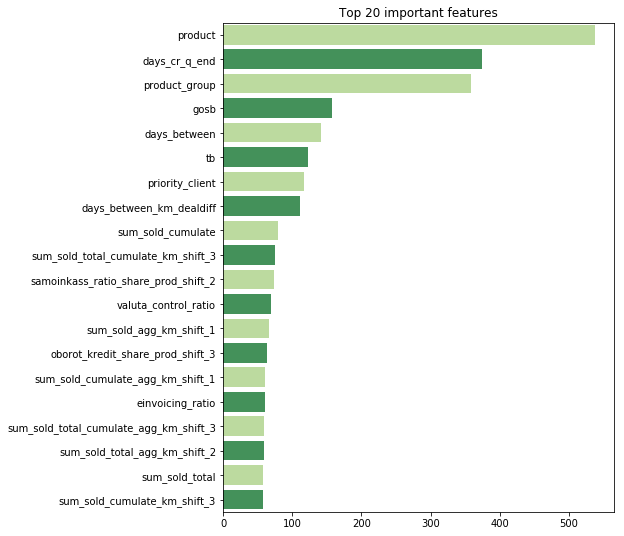

In [191]:
feature_impotance(rfe.estimator, X_train, count_top_features = 20)

In [156]:
data=[]
for scores_val, names in zip(scores,split_names):

    data.append(
                    go.Scatter(
                                x=list(range(1, len(scores_val) + 1)), 
                                y=scores_val,
                                mode='lines+markers',
                                name= names
                               )   
    )
fig=go.Figure(data=data, layout=go.Layout(showlegend=True))
py.iplot(data, filename='show-legend')

In [133]:
impotant_columns = [col[0] for col in sorted(zip(X.columns, rfe.estimator.feature_importances_), key=lambda x: x[1], reverse=True)[:30]] 

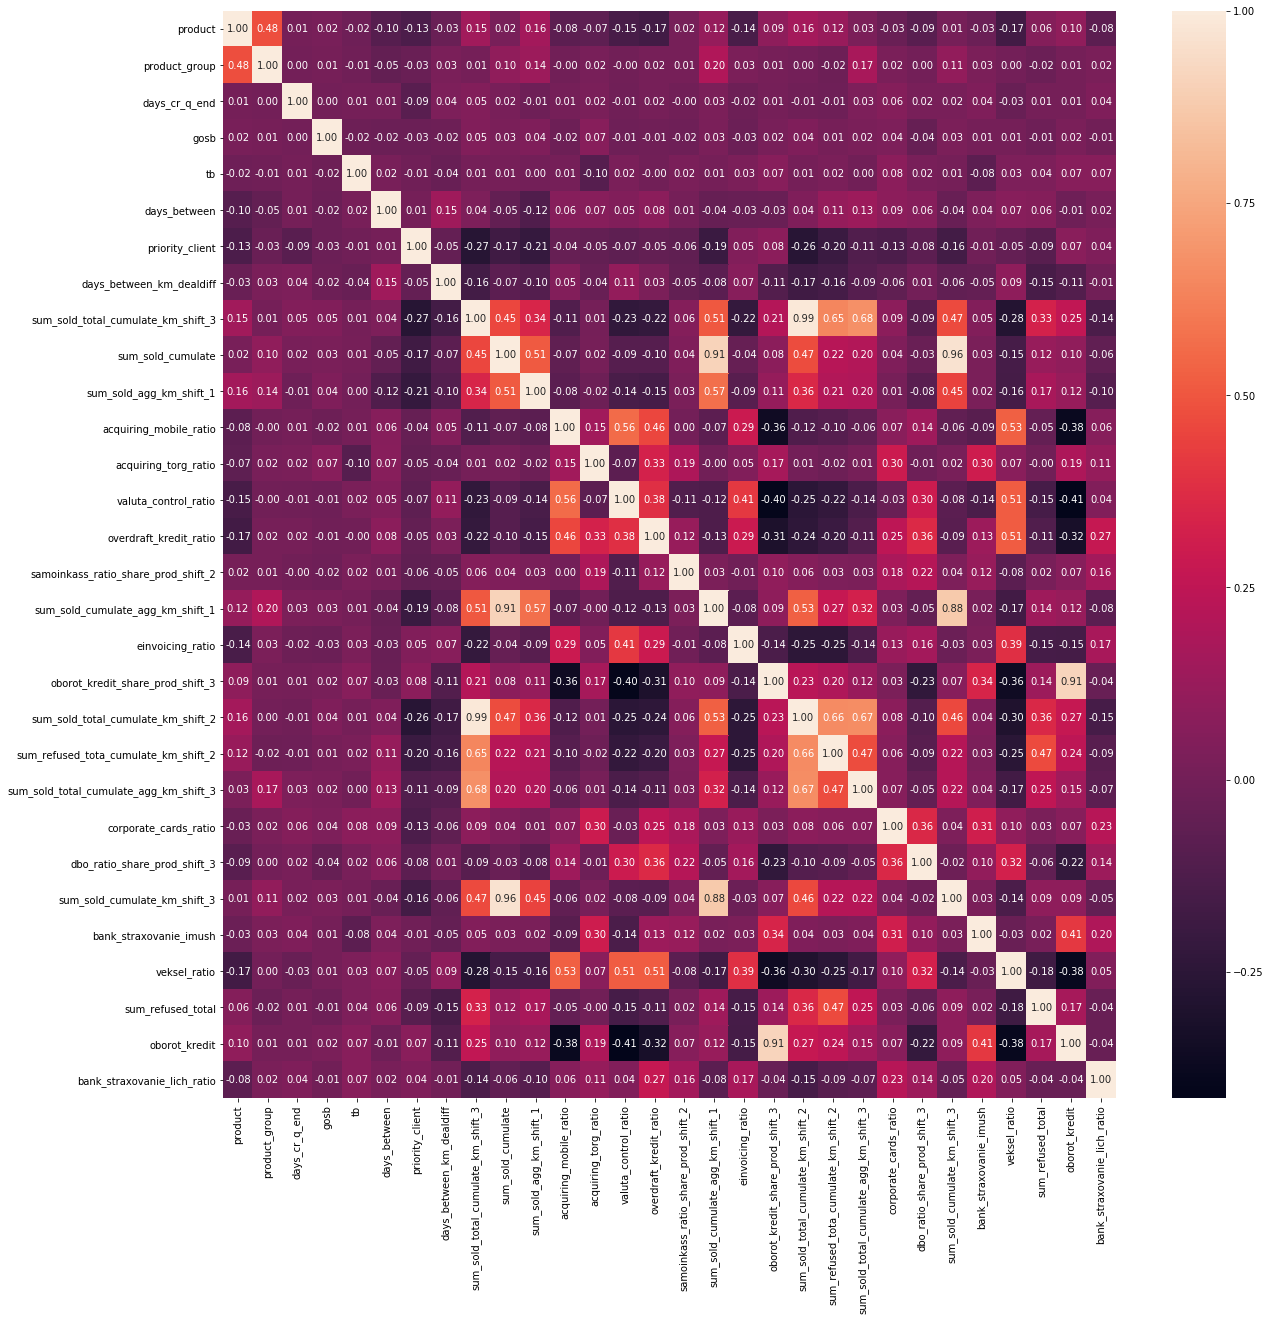

In [134]:
plt.figure(figsize=(20, 20))
sns.heatmap(X[impotant_columns].corr(method='pearson'), annot=True, fmt='.2f')

In [226]:
impotant_columns = [col[0] for col in sorted(zip(X_train.columns, rfe.estimator.feature_importances_), 
                                             key=lambda x: x[1], reverse=True)[:rfe.n_features_+1]] 
corr_arr=X_train[impotant_columns].corr(method='pearson')

In [227]:
high_corr=corr_arr[(abs(corr_arr)>=0.5) & (abs(corr_arr)<=1.)]
high_corr.fillna(-1, inplace=True)
high_corr.head()

product  days_cr_q_end  product_group  gosb  days_between   tb  \
product            1.0           -1.0           -1.0  -1.0          -1.0 -1.0   
days_cr_q_end     -1.0            1.0           -1.0  -1.0          -1.0 -1.0   
product_group     -1.0           -1.0            1.0  -1.0          -1.0 -1.0   
gosb              -1.0           -1.0           -1.0   1.0          -1.0 -1.0   
days_between      -1.0           -1.0           -1.0  -1.0           1.0 -1.0   

               priority_client  days_between_km_dealdiff  sum_sold_cumulate  \
product                   -1.0                      -1.0               -1.0   
days_cr_q_end             -1.0                      -1.0               -1.0   
product_group             -1.0                      -1.0               -1.0   
gosb                      -1.0                      -1.0               -1.0   
days_between              -1.0                      -1.0               -1.0   

               sum_sold_total_cumulate_km_shift_3  \
product                                      -1.0   
days_cr_q_end                                -1.0   
product_group                                -1.0   
gosb                                         -1.0   
days_between                                 -1.0   

               samoinkass_ratio_share_prod_shift_2  valuta_control_ratio  \
product                                       -1.0                  -1.0   
days_cr_q_end                                 -1.0                  -1.0   
product_group                                 -1.0                  -1.0   
gosb                                          -1.0                  -1.0   
days_between                                  -1.0                  -1.0   

               sum_sold_agg_km_shift_1  oborot_kredit_share_prod_shift_3  \
product                           -1.0                              -1.0   
days_cr_q_end                     -1.0                              -1.0   
product_group                     -1.0                              -1.0   
gosb                              -1.0                              -1.0   
days_between                      -1.0                              -1.0   

               sum_sold_cumulate_agg_km_shift_1  einvoicing_ratio  \
product                                    -1.0              -1.0   
days_cr_q_end                              -1.0              -1.0   
product_group                              -1.0              -1.0   
gosb                                       -1.0              -1.0   
days_between                               -1.0              -1.0   

               sum_sold_total_agg_km_shift_2  \
product                                 -1.0   
days_cr_q_end                           -1.0   
product_group                           -1.0   
gosb                                    -1.0   
days_between                            -1.0   

               sum_sold_total_cumulate_agg_km_shift_3  sum_sold_total  \
product                                          -1.0            -1.0   
days_cr_q_end                                    -1.0            -1.0   
product_group                                    -1.0            -1.0   
gosb                                             -1.0            -1.0   
days_between                                     -1.0            -1.0   

               sum_sold_cumulate_km_shift_3  acquiring_mobile_ratio  \
product                                -1.0                    -1.0   
days_cr_q_end                          -1.0                    -1.0   
product_group                          -1.0                    -1.0   
gosb                                   -1.0                    -1.0   
days_between                           -1.0                    -1.0   

               sum_refused_total  bank_straxovanie_lich_ratio  \
product                     -1.0                         -1.0   
days_cr_q_end               -1.0                         -1.0   
product_group               -1.0                       

In [228]:
import math
top_corr_features=[]
from collections import OrderedDict
corr_list=[]
for i in range(len(high_corr.index)):
    for j in range(len(high_corr.index)):
        if j>=i:
            if (high_corr.iloc[j,i]!=-1.):
                corr_list.append([high_corr.index[j],high_corr.columns[i]])
top_corr_features=list(OrderedDict.fromkeys(np.hstack(corr_list)))
top_corr_features

['product',
 'days_cr_q_end',
 'product_group',
 'gosb',
 'days_between',
 'tb',
 'priority_client',
 'days_between_km_dealdiff',
 'sum_sold_cumulate',
 'sum_sold_agg_km_shift_1',
 'sum_sold_cumulate_agg_km_shift_1',
 'sum_sold_cumulate_km_shift_3',
 'sum_sold_cumulate_km_shift_2',
 'sum_sold_cumulate_agg_km_shift_2',
 'sum_sold',
 'sum_sold_total_cumulate_km_shift_3',
 'sum_sold_total_cumulate_agg_km_shift_3',
 'sum_sold_total',
 'sum_refused_tota_cumulate_km_shift_3',
 'sum_sold_total_cumulate_agg_km_shift_1',
 'sum_refused_tota_cumulate',
 'sum_sold_total_cumulate',
 'sum_sold_total_km_shift_3',
 'sum_sold_total_cumulate_agg_km_shift_2',
 'sum_refused_tota_cumulate_km_shift_2',
 'samoinkass_ratio_share_prod_shift_2',
 'samoinkass_ratio',
 'samoinkass_ratio_share_prod_shift_3',
 'valuta_control_ratio',
 'acquiring_mobile_ratio',
 'valuta_control_ratio_share_prod_shift_2',
 'obsluzh_rts_val_ratio_share_prod_shift_3',
 'deposit_ratio',
 'valuta_control_ratio_share_prod_shift_3',
 'depo

In [230]:
X_train.shape, len(top_corr_features)

((270259, 266), 101)

In [231]:
joblib.dump(top_corr_features, 'pkl_store/top_corr_features_le_trn.pkl')

['pkl_store/top_corr_features_le_trn.pkl']

## Evaluate a score by Cross Validation 

In [163]:
from sklearn.model_selection import cross_val_score

In [164]:
gbm = LGBMClassifier(n_estimators=10000, num_leaves=10, max_bin=100, bagging_freq=10, n_jobs=20, feature_fraction=0.5,\
                    min_data_in_leaf=100,  silent=False, random_state=42)

gbm.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=15,
        eval_metric=['auc', 'logloss'], categorical_feature=cat_features, verbose=100)

Training until validation scores don't improve for 15 rounds.
[100]	training's auc: 0.866779	valid_1's auc: 0.865345
[200]	training's auc: 0.873942	valid_1's auc: 0.869267
[300]	training's auc: 0.878905	valid_1's auc: 0.871359
[400]	training's auc: 0.883125	valid_1's auc: 0.873169
[500]	training's auc: 0.886982	valid_1's auc: 0.874648
[600]	training's auc: 0.890147	valid_1's auc: 0.875575
[700]	training's auc: 0.893168	valid_1's auc: 0.876455
Early stopping, best iteration is:
[752]	training's auc: 0.894638	valid_1's auc: 0.876817


LGBMClassifier(bagging_freq=10, boosting_type='gbdt', colsample_bytree=1.0,
        feature_fraction=0.5, learning_rate=0.1, max_bin=100, max_depth=-1,
        min_child_samples=10, min_child_weight=5, min_data_in_leaf=100,
        min_split_gain=0.0, n_estimators=10000, n_jobs=20, num_leaves=10,
        objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
        silent=False, subsample=1.0, subsample_for_bin=50000,
        subsample_freq=1)

AUC: 0.87682, Precision: 0.85586, Recall: 0.91570, F1: 0.88477 

Average precision: 0.95179 

             precision    recall  f1-score   support

          0    0.69873   0.55905   0.62113     37707
          1    0.85586   0.91570   0.88477    107818

avg / total    0.81515   0.82329   0.81646    145525



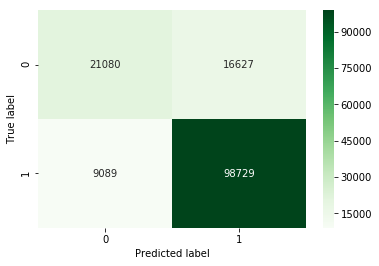

In [165]:
predict(gbm, X_test, y_test)

In [213]:
gbm = LGBMClassifier(n_estimators=430, num_leaves=10, max_bin=100, bagging_freq=10, n_jobs=10, feature_fraction=0.5,\
                    min_data_in_leaf=100,  silent=False, random_state=42)
average_precision_scores = cross_val_score(gbm, X_train, y_train, scoring='average_precision', cv=StratifiedKFold(5))
print('average_precision: {0:.5f} +- {1:.5f}'.format(average_precision_scores.mean(), average_precision_scores.std()))

average_precision: 0.94616 +- 0.00037


In [210]:
average_precision_scores

array([0.94742178, 0.94520071, 0.94654138, 0.94739226, 0.94817883])

In [222]:
gbm = LGBMClassifier(n_estimators=430, num_leaves=10, max_bin=100, bagging_freq=10, n_jobs=10, feature_fraction=0.5,\
                     min_data_in_leaf=100,  silent=False, random_state=42)
scores = cross_validate(gbm, X_train, y_train, scoring=['roc_auc'], cv=StratifiedShuffleSplit(3))

In [217]:
scores

/home/ektov-av/python35-libs/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning:

You are accessing a training score ('train_roc_auc'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True



{'fit_time': array([15.29183483, 15.3836925 , 15.44453883]),
 'score_time': array([0.26592565, 0.26630092, 0.26542711]),
 'test_roc_auc': array([0.86824092, 0.86798262, 0.8674408 ]),
 'train_roc_auc': array([0.87543945, 0.87575025, 0.87553218])}

## Tables impotance

In [189]:
df = pd.read_pickle('pkl_store/total_dataset.pkl')
total_col=pd.read_pickle('pkl_store/df_columns_dict.pkl')

In [190]:
balance = pd.concat([df.groupby('product_group')['is_sold'].sum(), df.groupby('product_group')['is_sold'].count()], axis=1)
balance.columns = ['Count of sold', 'Count']
balance['balance'] = balance['Count of sold'] / balance['Count']
balance = balance.sort_values('balance', ascending=False)
product_groups_without_balance = list(balance[(balance['balance'] == 1) | (balance['balance'] == 0)].index)
df = df[~df['product_group'].isin(product_groups_without_balance)]

In [223]:
target_column = 'is_sold'
X, y = df.drop(target_column, axis = 1), df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.35, random_state=42)

All columns
Training until validation scores don't improve for 15 rounds.
[50]	training's auc: 0.859095	valid_1's auc: 0.857522
[100]	training's auc: 0.867069	valid_1's auc: 0.864186
[150]	training's auc: 0.871703	valid_1's auc: 0.8672
[200]	training's auc: 0.874475	valid_1's auc: 0.86853
[250]	training's auc: 0.877004	valid_1's auc: 0.869686
[300]	training's auc: 0.879726	valid_1's auc: 0.871026
[350]	training's auc: 0.881753	valid_1's auc: 0.87179
[400]	training's auc: 0.883821	valid_1's auc: 0.872701
[450]	training's auc: 0.885544	valid_1's auc: 0.873245
[500]	training's auc: 0.887273	valid_1's auc: 0.873841
[550]	training's auc: 0.888841	valid_1's auc: 0.874311
[600]	training's auc: 0.890427	valid_1's auc: 0.874881
[650]	training's auc: 0.891878	valid_1's auc: 0.875226
[700]	training's auc: 0.893336	valid_1's auc: 0.875682
[750]	training's auc: 0.894709	valid_1's auc: 0.876062
[800]	training's auc: 0.896085	valid_1's auc: 0.876468
[850]	training's auc: 0.897196	valid_1's auc: 0.876

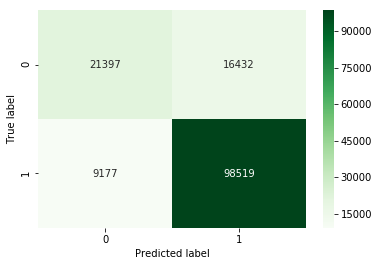

--------------------------------------------------------------------------------
df_kp_company_aggregates
Training until validation scores don't improve for 15 rounds.
[50]	training's auc: 0.857668	valid_1's auc: 0.85714
[100]	training's auc: 0.866309	valid_1's auc: 0.864654
[150]	training's auc: 0.871424	valid_1's auc: 0.868389
[200]	training's auc: 0.874129	valid_1's auc: 0.869885
[250]	training's auc: 0.876279	valid_1's auc: 0.870834
[300]	training's auc: 0.8786	valid_1's auc: 0.872067
[350]	training's auc: 0.880591	valid_1's auc: 0.873052
[400]	training's auc: 0.88235	valid_1's auc: 0.87381
[450]	training's auc: 0.884121	valid_1's auc: 0.874615
[500]	training's auc: 0.885764	valid_1's auc: 0.875357
[550]	training's auc: 0.887216	valid_1's auc: 0.875828
[600]	training's auc: 0.888535	valid_1's auc: 0.876264
[650]	training's auc: 0.889932	valid_1's auc: 0.876665
[700]	training's auc: 0.891349	valid_1's auc: 0.877151
[750]	training's auc: 0.89272	valid_1's auc: 0.877588
[800]	training

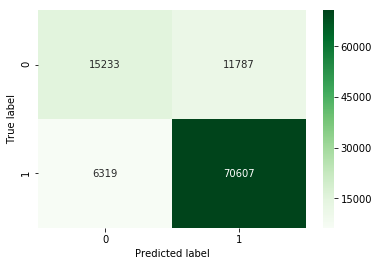

Full AUC - current AUC: -0.0014550831579580592
Full AVP - current AVP: -0.0007508507996614178
--------------------------------------------------------------------------------
df_kp_deal
Training until validation scores don't improve for 15 rounds.
[50]	training's auc: 0.83746	valid_1's auc: 0.836881
[100]	training's auc: 0.843386	valid_1's auc: 0.842063
[150]	training's auc: 0.84622	valid_1's auc: 0.843712
[200]	training's auc: 0.84858	valid_1's auc: 0.844916
[250]	training's auc: 0.850567	valid_1's auc: 0.84579
[300]	training's auc: 0.852412	valid_1's auc: 0.846624
[350]	training's auc: 0.854086	valid_1's auc: 0.847344
[400]	training's auc: 0.855726	valid_1's auc: 0.847979
[450]	training's auc: 0.857191	valid_1's auc: 0.848531
[500]	training's auc: 0.858662	valid_1's auc: 0.849113
[550]	training's auc: 0.860085	valid_1's auc: 0.84975
[600]	training's auc: 0.861399	valid_1's auc: 0.850126
[650]	training's auc: 0.862751	valid_1's auc: 0.850605
Early stopping, best iteration is:
[680]	tr

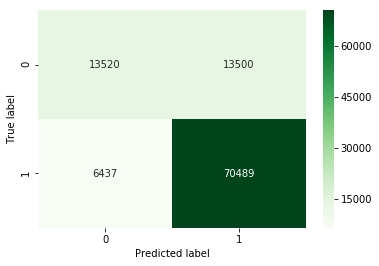

Full AUC - current AUC: 0.028029112079188345
Full AVP - current AVP: 0.013716137362366876
--------------------------------------------------------------------------------
df_kp_company
Training until validation scores don't improve for 15 rounds.
[50]	training's auc: 0.845227	valid_1's auc: 0.844203
[100]	training's auc: 0.853167	valid_1's auc: 0.851088
[150]	training's auc: 0.857631	valid_1's auc: 0.854316
[200]	training's auc: 0.860409	valid_1's auc: 0.855687
[250]	training's auc: 0.862789	valid_1's auc: 0.856962
[300]	training's auc: 0.865339	valid_1's auc: 0.858434
[350]	training's auc: 0.867408	valid_1's auc: 0.859437
[400]	training's auc: 0.869145	valid_1's auc: 0.86031
[450]	training's auc: 0.871099	valid_1's auc: 0.861253
[500]	training's auc: 0.872929	valid_1's auc: 0.862125
[550]	training's auc: 0.874497	valid_1's auc: 0.862774
[600]	training's auc: 0.876111	valid_1's auc: 0.863359
[650]	training's auc: 0.877642	valid_1's auc: 0.864032
[700]	training's auc: 0.879043	valid_1's

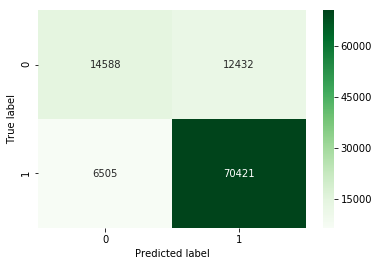

Full AUC - current AUC: 0.009969367927556427
Full AVP - current AVP: 0.0036557232500242787
--------------------------------------------------------------------------------
df_kp_share_prod
Training until validation scores don't improve for 15 rounds.
[50]	training's auc: 0.858031	valid_1's auc: 0.85764
[100]	training's auc: 0.866273	valid_1's auc: 0.864833
[150]	training's auc: 0.869946	valid_1's auc: 0.867323
[200]	training's auc: 0.872471	valid_1's auc: 0.868741
[250]	training's auc: 0.875132	valid_1's auc: 0.87011
[300]	training's auc: 0.877353	valid_1's auc: 0.871288
[350]	training's auc: 0.879837	valid_1's auc: 0.872708
[400]	training's auc: 0.881652	valid_1's auc: 0.873473
[450]	training's auc: 0.883366	valid_1's auc: 0.87425
[500]	training's auc: 0.88486	valid_1's auc: 0.874912
[550]	training's auc: 0.886523	valid_1's auc: 0.875593
[600]	training's auc: 0.887854	valid_1's auc: 0.876031
[650]	training's auc: 0.889065	valid_1's auc: 0.876465
[700]	training's auc: 0.890432	valid_1'

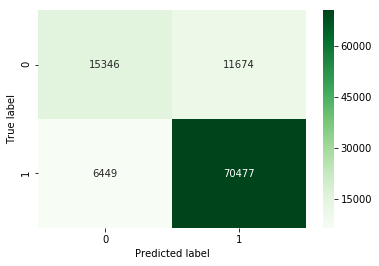

Full AUC - current AUC: -0.0016720250437001205
Full AVP - current AVP: -0.0007174744808867706
--------------------------------------------------------------------------------
df_comp_dealdiff
Training until validation scores don't improve for 15 rounds.
[50]	training's auc: 0.857839	valid_1's auc: 0.857368
[100]	training's auc: 0.865488	valid_1's auc: 0.86364
[150]	training's auc: 0.870014	valid_1's auc: 0.86683
[200]	training's auc: 0.872507	valid_1's auc: 0.868125
[250]	training's auc: 0.874767	valid_1's auc: 0.869191
[300]	training's auc: 0.877335	valid_1's auc: 0.870731
[350]	training's auc: 0.879336	valid_1's auc: 0.871658
[400]	training's auc: 0.881141	valid_1's auc: 0.872367
[450]	training's auc: 0.88279	valid_1's auc: 0.872939
[500]	training's auc: 0.884311	valid_1's auc: 0.873546
[550]	training's auc: 0.885875	valid_1's auc: 0.874119
[600]	training's auc: 0.887395	valid_1's auc: 0.874691
[650]	training's auc: 0.888736	valid_1's auc: 0.875056
[700]	training's auc: 0.890013	vali

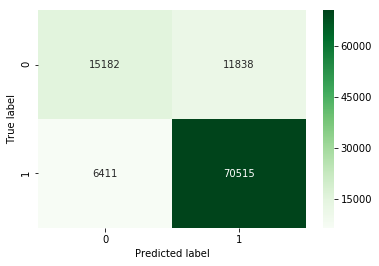

Full AUC - current AUC: -0.000637535227740349
Full AVP - current AVP: -0.0004529180073751249
--------------------------------------------------------------------------------
df_km_dealdiff
Training until validation scores don't improve for 15 rounds.
[50]	training's auc: 0.857839	valid_1's auc: 0.857368
[100]	training's auc: 0.865488	valid_1's auc: 0.86364
[150]	training's auc: 0.870014	valid_1's auc: 0.86683
[200]	training's auc: 0.872507	valid_1's auc: 0.868125
[250]	training's auc: 0.874767	valid_1's auc: 0.869191
[300]	training's auc: 0.877335	valid_1's auc: 0.870731
[350]	training's auc: 0.879336	valid_1's auc: 0.871658
[400]	training's auc: 0.881141	valid_1's auc: 0.872367
[450]	training's auc: 0.88279	valid_1's auc: 0.872939
[500]	training's auc: 0.884311	valid_1's auc: 0.873546
[550]	training's auc: 0.885875	valid_1's auc: 0.874119
[600]	training's auc: 0.887395	valid_1's auc: 0.874691
[650]	training's auc: 0.888736	valid_1's auc: 0.875056
[700]	training's auc: 0.890013	valid_1

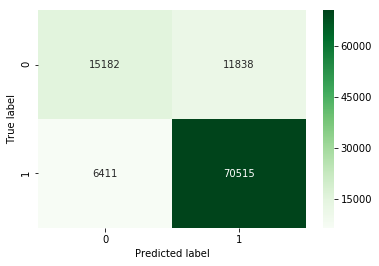

Full AUC - current AUC: -0.000637535227740349
Full AVP - current AVP: -0.0004529180073751249
--------------------------------------------------------------------------------
df_kp_km_aggregates
Training until validation scores don't improve for 15 rounds.
[50]	training's auc: 0.857845	valid_1's auc: 0.857109
[100]	training's auc: 0.867052	valid_1's auc: 0.865227
[150]	training's auc: 0.870808	valid_1's auc: 0.867677
[200]	training's auc: 0.873597	valid_1's auc: 0.869246
[250]	training's auc: 0.875977	valid_1's auc: 0.870491
[300]	training's auc: 0.878089	valid_1's auc: 0.871458
[350]	training's auc: 0.880175	valid_1's auc: 0.872521
[400]	training's auc: 0.88215	valid_1's auc: 0.873387
[450]	training's auc: 0.883927	valid_1's auc: 0.87405
[500]	training's auc: 0.885503	valid_1's auc: 0.874586
[550]	training's auc: 0.886894	valid_1's auc: 0.875015
[600]	training's auc: 0.888291	valid_1's auc: 0.875549
[650]	training's auc: 0.88967	valid_1's auc: 0.875991
[700]	training's auc: 0.891166	va

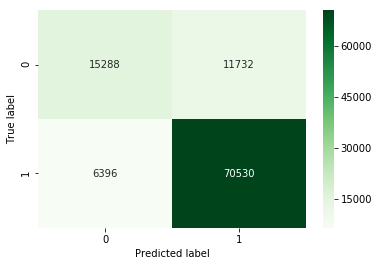

Full AUC - current AUC: -0.0016155019695190953
Full AVP - current AVP: -0.0008530218489515295


In [192]:
print('All columns')

gbm = LGBMClassifier(n_estimators=10000, num_leaves=10, max_bin=100, bagging_freq=10, n_jobs=20, feature_fraction=0.5,\
                    min_data_in_leaf=100,  silent=False, random_state=42)
gbm.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=15,
        eval_metric=['auc', 'logloss'], categorical_feature=cat_features, verbose=50)
predict(gbm, X_test, y_test)
y_pred_proba = gbm.predict_proba(X_test)[:, 1]
full_auc = roc_auc_score(y_test, y_pred_proba)
full_avp = average_precision_score(y_test, y_pred_proba)
data = []
data.append(['All columns', full_auc, full_avp, 0, 0])

for key in total_col:
    print('-' * 80)
    print(key)
    df_temp = df.drop(total_col[key], axis=1, errors='ignore')
    
    X, y = df_temp.drop(target_column, axis = 1, errors='ignore'), df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
    
    gbm.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=15,
        eval_metric=['auc', 'logloss'], categorical_feature=[col for col in cat_features if col in df_temp.columns], verbose=50)
    
    predict(gbm, X_test, y_test)
    y_pred_proba = gbm.predict_proba(X_test)[:, 1]
    current_auc = roc_auc_score(y_test, y_pred_proba)
    current_avp = average_precision_score(y_test, y_pred_proba)
    print('Full AUC - current AUC:', full_auc - current_auc)
    print('Full AVP - current AVP:', full_avp - current_avp)
    data.append([key, current_auc, current_avp, full_auc - current_auc, full_avp - current_avp])
    
tables_impotence = pd.DataFrame(data, columns=['Table name', 'AUC', 'AVP', 'Full AUC - current AUC', 'Full AVP - current AVP'])

In [194]:
tables_impotence.sort_values('Full AUC - current AUC', ascending=False).head(100)

Table name       AUC       AVP  Full AUC - current AUC  \
2                df_kp_deal  0.850917  0.938763                0.028029   
3             df_kp_company  0.868976  0.948824                0.009969   
0               All columns  0.878946  0.952479                0.000000   
5          df_comp_dealdiff  0.879583  0.952932               -0.000638   
6            df_km_dealdiff  0.879583  0.952932               -0.000638   
1  df_kp_company_aggregates  0.880401  0.953230               -0.001455   
7       df_kp_km_aggregates  0.880561  0.953332               -0.001616   
4          df_kp_share_prod  0.880618  0.953197               -0.001672   

   Full AVP - current AVP  
2                0.013716  
3                0.003656  
0                0.000000  
5               -0.000453  
6               -0.000453  
1               -0.000751  
7               -0.000853  
4               -0.000717

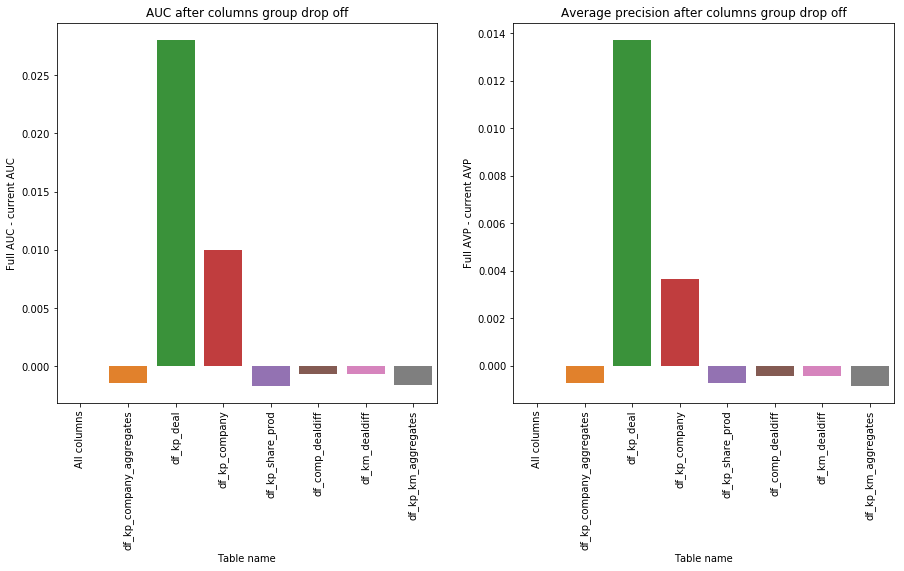

In [195]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15, 7))
fig1 = sns.barplot(x='Table name', y='Full AUC - current AUC', data=tables_impotence, ax=ax1)
fig1.set(title='AUC after column''s group drop off')

fig2 = sns.barplot(x='Table name', y='Full AVP - current AVP', data=tables_impotence, ax=ax2)
_, labels = plt.xticks()
fig1.set_xticklabels(labels, rotation=90)
fig2.set_xticklabels(labels, rotation=90)
fig2.set(title='Average precision after column''s group drop off')

plt.show()

--------------------------------------------------------------------------------
df_kp_km_aggregates
Training until validation scores don't improve for 15 rounds.
[50]	training's auc: 0.857845	valid_1's auc: 0.857109
[100]	training's auc: 0.867052	valid_1's auc: 0.865227
[150]	training's auc: 0.870808	valid_1's auc: 0.867677
[200]	training's auc: 0.873597	valid_1's auc: 0.869246
[250]	training's auc: 0.875977	valid_1's auc: 0.870491
[300]	training's auc: 0.878089	valid_1's auc: 0.871458
[350]	training's auc: 0.880175	valid_1's auc: 0.872521
[400]	training's auc: 0.88215	valid_1's auc: 0.873387
[450]	training's auc: 0.883927	valid_1's auc: 0.87405
[500]	training's auc: 0.885503	valid_1's auc: 0.874586
[550]	training's auc: 0.886894	valid_1's auc: 0.875015
[600]	training's auc: 0.888291	valid_1's auc: 0.875549
[650]	training's auc: 0.88967	valid_1's auc: 0.875991
[700]	training's auc: 0.891166	valid_1's auc: 0.8766
[750]	training's auc: 0.892438	valid_1's auc: 0.877093
[800]	training's a

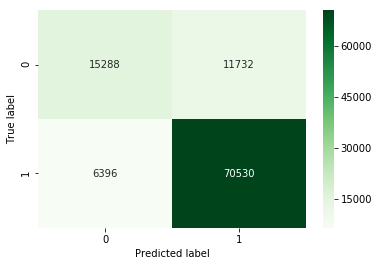

Full AUC - current AUC: -0.0016155019695190953
Full AVP - current AVP: -0.0008530218489515295
--------------------------------------------------------------------------------
df_kp_company_aggregates
Training until validation scores don't improve for 15 rounds.
[50]	training's auc: 0.856673	valid_1's auc: 0.856281
[100]	training's auc: 0.865782	valid_1's auc: 0.864304
[150]	training's auc: 0.869716	valid_1's auc: 0.867004
[200]	training's auc: 0.872558	valid_1's auc: 0.868484
[250]	training's auc: 0.874988	valid_1's auc: 0.869812
[300]	training's auc: 0.877902	valid_1's auc: 0.871589
[350]	training's auc: 0.880004	valid_1's auc: 0.872601
[400]	training's auc: 0.88186	valid_1's auc: 0.873442
[450]	training's auc: 0.883591	valid_1's auc: 0.874047
[500]	training's auc: 0.885241	valid_1's auc: 0.874682
[550]	training's auc: 0.886718	valid_1's auc: 0.875253
[600]	training's auc: 0.888095	valid_1's auc: 0.875673
[650]	training's auc: 0.889479	valid_1's auc: 0.876179
[700]	training's auc: 0.8

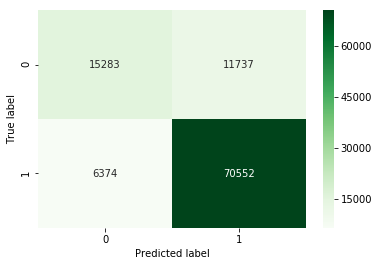

Full AUC - current AUC: -0.0018095489443648027
Full AVP - current AVP: -0.0008813307398291004
--------------------------------------------------------------------------------
df_kp_share_prod
Training until validation scores don't improve for 15 rounds.
[50]	training's auc: 0.858348	valid_1's auc: 0.858139
[100]	training's auc: 0.866343	valid_1's auc: 0.865061
[150]	training's auc: 0.87038	valid_1's auc: 0.867811
[200]	training's auc: 0.8733	valid_1's auc: 0.869542
[250]	training's auc: 0.875924	valid_1's auc: 0.871025
[300]	training's auc: 0.878106	valid_1's auc: 0.872103
[350]	training's auc: 0.880222	valid_1's auc: 0.873286
[400]	training's auc: 0.882096	valid_1's auc: 0.874105
[450]	training's auc: 0.883603	valid_1's auc: 0.874586
[500]	training's auc: 0.885208	valid_1's auc: 0.875285
[550]	training's auc: 0.886632	valid_1's auc: 0.875814
[600]	training's auc: 0.887969	valid_1's auc: 0.876136
[650]	training's auc: 0.889334	valid_1's auc: 0.876552
[700]	training's auc: 0.890725	vali

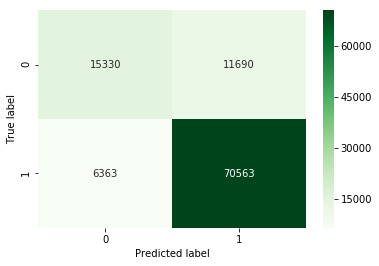

Full AUC - current AUC: -0.0018589165169535793
Full AVP - current AVP: -0.000891221524400021
--------------------------------------------------------------------------------
df_comp_dealdiff
Training until validation scores don't improve for 15 rounds.
[50]	training's auc: 0.857416	valid_1's auc: 0.856828
[100]	training's auc: 0.865166	valid_1's auc: 0.863652
[150]	training's auc: 0.869195	valid_1's auc: 0.866398
[200]	training's auc: 0.871849	valid_1's auc: 0.867828
[250]	training's auc: 0.874195	valid_1's auc: 0.86905
[300]	training's auc: 0.876307	valid_1's auc: 0.870092
[350]	training's auc: 0.878228	valid_1's auc: 0.871069
[400]	training's auc: 0.880038	valid_1's auc: 0.871791
[450]	training's auc: 0.881621	valid_1's auc: 0.872371
[500]	training's auc: 0.883343	valid_1's auc: 0.873181
[550]	training's auc: 0.884816	valid_1's auc: 0.873757
[600]	training's auc: 0.886178	valid_1's auc: 0.874238
[650]	training's auc: 0.887525	valid_1's auc: 0.874697
[700]	training's auc: 0.888738	val

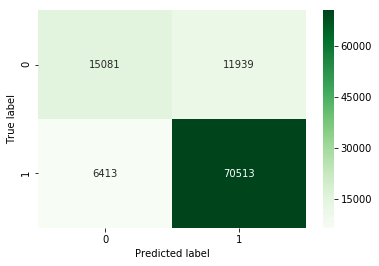

Full AUC - current AUC: 0.0004765229191753262
Full AVP - current AVP: 0.00014448848465231645
--------------------------------------------------------------------------------
df_km_dealdiff
Training until validation scores don't improve for 15 rounds.
[50]	training's auc: 0.857416	valid_1's auc: 0.856828
[100]	training's auc: 0.865166	valid_1's auc: 0.863652
[150]	training's auc: 0.869195	valid_1's auc: 0.866398
[200]	training's auc: 0.871849	valid_1's auc: 0.867828
[250]	training's auc: 0.874195	valid_1's auc: 0.86905
[300]	training's auc: 0.876307	valid_1's auc: 0.870092
[350]	training's auc: 0.878228	valid_1's auc: 0.871069
[400]	training's auc: 0.880038	valid_1's auc: 0.871791
[450]	training's auc: 0.881621	valid_1's auc: 0.872371
[500]	training's auc: 0.883343	valid_1's auc: 0.873181
[550]	training's auc: 0.884816	valid_1's auc: 0.873757
[600]	training's auc: 0.886178	valid_1's auc: 0.874238
[650]	training's auc: 0.887525	valid_1's auc: 0.874697
[700]	training's auc: 0.888738	valid

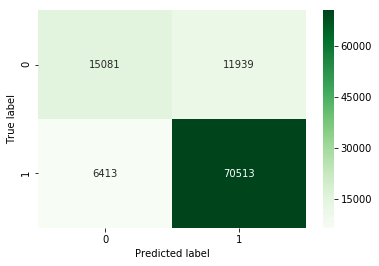

Full AUC - current AUC: 0.0004765229191753262
Full AVP - current AVP: 0.00014448848465231645


In [197]:
data = []
df_temp = df
for table in tables_impotence[tables_impotence['Full AVP - current AVP'] < 0.001]\
    .sort_values('Full AVP - current AVP').drop(0)['Table name']:
        
    print('-' * 80)
    print(table)
    df_temp = df_temp.drop(total_col[table], axis=1, errors='ignore')
    
    X, y = df_temp.drop(target_column, axis = 1, errors='ignore'), df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
    
    gbm.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=15,
        eval_metric=['auc', 'logloss'], categorical_feature=[col for col in cat_features if col in df_temp.columns], verbose=50)
    
    predict(gbm, X_test, y_test)
    y_pred_proba = gbm.predict_proba(X_test)[:, 1]
    current_auc = roc_auc_score(y_test, y_pred_proba)
    current_avp = average_precision_score(y_test, y_pred_proba)
    print('Full AUC - current AUC:', full_auc - current_auc)
    print('Full AVP - current AVP:', full_avp - current_avp)
    data.append([table, current_auc, current_avp, full_auc - current_auc, full_avp - current_avp])

In [198]:
tables_drop_impotences = pd.DataFrame(data, columns=['Table', 'AUC', 'AVP', 'Full AUC - current AUC', 'Full AVP - current AVP'])
tables_drop_impotences.head(10)

Table       AUC       AVP  Full AUC - current AUC  \
0       df_kp_km_aggregates  0.880561  0.953332               -0.001616   
1  df_kp_company_aggregates  0.880755  0.953361               -0.001810   
2          df_kp_share_prod  0.880805  0.953371               -0.001859   
3          df_comp_dealdiff  0.878469  0.952335                0.000477   
4            df_km_dealdiff  0.878469  0.952335                0.000477   

   Full AVP - current AVP  
0               -0.000853  
1               -0.000881  
2               -0.000891  
3                0.000144  
4                0.000144

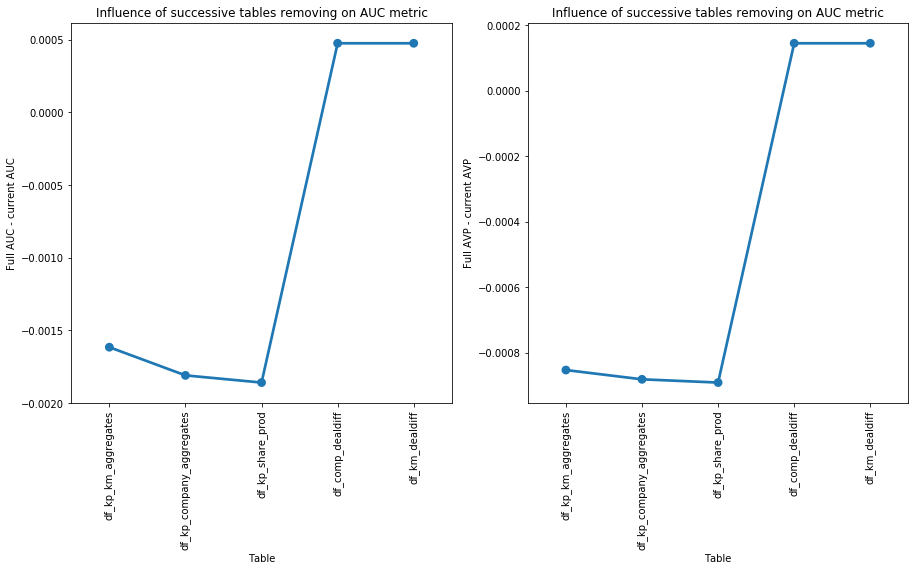

In [200]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
ax[0].tick_params(axis='x', rotation=90)
ax[0].set(title='Influence of successive tables removing on AUC metric')
sns.pointplot(x='Table', y='Full AUC - current AUC', data=tables_drop_impotences, ax=ax[0])

ax[1].tick_params(axis='x', rotation=90)
ax[1].set(title='Influence of successive tables removing on AUC metric')
sns.pointplot(x='Table', y='Full AVP - current AVP', data=tables_drop_impotences, ax=ax[1])